# Lead question: What factors lead to the hotspots located on the Greek islands consistently suffering from overcapacity and overcrowdness?

3 December 2018

**By Ioannis Antypas**

# Overview  

The hotspots in Greece were established as a way to regulate as much as possible the massive flows of irregular migrants and asylum seekers from the coasts of Turkey to the Greek islands. They would act as a gate to Europe, welcoming persons who cross the sea, providing for them, and examining their asylum applications. In the event that they are deemed inadmissible, after a deal with Turkey, known as the EU - Turkey Statement, they would be returned to Turkey. Funds of 1.6 billion euros were mobilized by the EU, and a relocation scheme was put in place, aiming to move up to 120.000 asylum seekers from Greece and Italy to the EU. With all this help why does the situation remain critical?

This story will examine data from the European Commission, UNHCR and the Greek Asylum service to find the following:

* Overcapacity in hotspots run by the Greek authorities and hotspots run jointly by the Greek authorities and NGOs in the islands of the Eastern Aegean
* A timeseries of the flows of migrants to the Greek islands and the amount of euros of emergency assistance allocated by the EU for the Greek islands
* Number of asylum applications per asylum worker at the beginning of each year in Greece
* Size of funds actually disbursed so far to Greece and what is their priorty area

# Background

Overcapacity is not a new problem in Greece. More and more reports surface about the horrible conditions and chaos that reigns in Greek hotspots (especially on the island of Lesvos) leading to dramatic humanitarian conditions and a rise of extremism within the hotspot premises. [https://p.dw.com/p/13TDH ,https://p.dw.com/p/35JwE, https://p.dw.com/p/35gua ]

The EU has mobilized considerable funds, and also made a controversial deal with Turkey called the EU - Turkey Statement which envisioned the latter halting migratory flows from its borders to Greece, and accepting irregular migrants deemed inadmissible for asylum, so why is there still such a problem?

Our analysis showed that there were two main factors. Initially there is the very slow pace of analysing asylum applications. By international law each application has to be examined inidividually. Not only is this a highly elaborate process, where applicants can appeal on multiple stages of the process, but as more and more applicants gather in the islands, asylum workers have to deal with an increased workload every year, compounding the difficulties. The second difficulty is the geographical restriction imposed by the EU - Turkey Statement. Basically Turkey has agreed to accept back migrants not eligible for asylum from the islands but not from the mainland. They say that they can’t be sure those migrants passed through Turkey and didn't go to, for example Italy, and then were sent to Greece. Hence the geographical restriction.


# Data selection

The European Commission has issued a number of factsheets and reports about the progress made and the state of play on the Greek islands. Drawing initially from this factsheet, https://ec.europa.eu/home-affairs/sites/homeaffairs/files/what-we-do/policies/european-agenda-migration/20180404-managing-migration-eu-financial-support-to-greece_en.pdf DW journalists requested from DG HOME to submit a detailed breakdown of what % of the allocated amounts listed in this factsheet have been disbursed so far. 

In order to understand just how far beyond capacity Greek hotspots are, we refered to the MINISTRY OF INTERIOR NATIONAL COORDINATION CENTER FOR BORDER CONTROL, IMMIGRATION AND ASYLUM (N.C.C.B.C.I.A.) and their daily datasets found here http://mindigital.gr/index.php/προσφυγικό-ζήτημα-refugee-crisis. DW journalists constructed a script that iterates over the urls for the year 2018 and downloads each pdf, then feeds it into a pdf reader and converted them to a CSV format. As there are multiple different reception centers, we made two categories, ones that are run solely by Greek authorities (R.I.C.,HELLENIC POLICE FACILITIES, N.C.S.S., OTHER ACCOMODATION FACILITIES) and those run by NGOs and Greek authorities (U.N.H.C.R, OTHER N.G.O.s). 

Data for the number of asylum seekers and asylum staff were found in the Greek Ministry of Migration Policy (http://asylo.gov.gr/?page_id=143 only in Greek). 

Data on migration flows was gathered from the UNHCR webpage on Greece https://data2.unhcr.org/en/situations/mediterranean/location/5179



In [1]:
import requests  
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
import pandas as pd
import glob
import calendar
import datetime
import time
import numpy as np
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pywaffle import Waffle
import json

/Users/ioannisantypas/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ioannisantypas/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Scraping the migration pdfs


All PDFs have been scrapped. This is part is optional

Goal to scrape pdfs in English from here 
http://mindigital.gr/index.php/προσφυγικό-ζήτημα-refugee-crisis

In [ ]:
# making a directory data to store our pdfs
os.mkdir('data')


In [ ]:
# building a list of dates to modify url requests for 2018
# example url http://mindigital.gr/images/prosfygiko/NSP_Eastern_Aegean_04.11.pdf
# 30.09 is our format
#  adapted from 
# https://stackoverflow.com/questions/47559084/creating-simple-list-from-calendar-dates-python
_, ndays = calendar.monthrange(2017, 12)
days_31 = list(range(1, ndays+1))

# https://stackoverflow.com/questions/29000613/add-leading-zeros-to-a-list-of-numbers-in-python
days_31 = ["{:02d}".format(item) for item in days_31]

months_31 = ['01','03','05','07','08','10','12']

_, ndays1 = calendar.monthrange(2017, 11)
days_30 = list(range(1, ndays1+1))

days_30 = ["{:02d}".format(item) for item in days_30]

months_30 = ['04','06','09','11']

_, ndays = calendar.monthrange(2017, 2)
days_28 = list(range(1, ndays+1))

days_28 = ["{:02d}".format(item) for item in days_28]

month_28 = ['02']

dates = []

dates_31 = []
for day in days_31:
    for month in months_31:
        dates.append(day +'.'+ month)
        
dates_30 = []
for day in days_30:
    for month in months_30:
        dates.append(day +'.'+ month)
        
dates_28 = []
for day in days_28:
    for month in month_28:
        dates.append(day +'.'+ month)

        
dates.sort()
len(dates)

In [ ]:
cd data

In [ ]:
# Scrapping the urls
# adapted from 
# https://stackoverflow.com/questions/43470535/python-download-pdf-embedded-in-a-page

for date in tqdm_notebook(dates):
    
    lnk = "http://mindigital.gr/images/prosfygiko/NSP_Eastern_Aegean_" +date+".pdf"

    options = webdriver.ChromeOptions()

    download_folder = "/data/PDF-data"

    profile = {"plugins.plugins_list": [{"enabled": False,
                                         "name": "Chrome PDF Viewer"}],
               "download.default_directory": download_folder,
               "download.extensions_to_open": ""}

    options.add_experimental_option("prefs", profile)

    print("Downloading file from link: {}".format(lnk))
    
    driver = webdriver.Chrome(chrome_options = options)

    time.sleep(1)
    driver.get(lnk)
    print("Status: Download Complete.")

    time.sleep(2)
    driver.close()


    time.sleep(3)
    new_name = date +'.18.pdf'
    try:
        os.rename('NSP_Eastern_Aegean_' + date + '.pdf', new_name)
        print('renamed to '+ new_name)
    except:
        print('Failed to rename')
        pass
    time.sleep(1)

cd ..

The result is our file `data` being filled with pdfs with data. We use ABBYY FineReader for Mac to convert them to CSV. Below are some screenshots of the process:

Example of a pdf file

<img src="screenshots/screenshot_1.png">

Example of a pdf analysis:

<img src="screenshots/screenshot_2.png">

Example of an output CSV

<img src="screenshots/screenshot_3.png">

We converted the pdfs to csv and save them into a new directory, `csv_data`


We had to manually rename some CSVs. Because of the url format which changed radically over the years, some results from 2017 were downloaded as well.

* 31.12.18.csv was changed to 31.12.17
* 30.12.18.csv was changed to 30.12.17
* 29.12.18.csv was changed to 29.12.17
* 27.12.18.csv was changed to 27.12.17
* 25.12.18.csv was changed to 25.12.17
* 24.12.18.csv was changed to 24.12.17
* 23.12.18.csv was changed to 23.12.17
* 22.12.18.csv was changed to 22.12.17
* 21.12.18.csv was changed to 21.12.17
* 20.12.18.csv was changed to 20.12.17
* 19.12.18.csv was changed to 19.12.17
* 18.12.18.csv was changed to 18.12.17
* 17.12.18.csv was changed to 17.12.17
* 16.12.18.csv was changed to 16.12.17
* 14.12.18.csv was changed to 14.12.17
* 13.12.18.csv was changed to 13.12.17
* 12.12.18.csv was changed to 12.12.17

 Then we had to also manually fix some errors:

* 12.12.17 extra column
* 13.12.17 extra column
* 14.12.17 extra column
* 16.12.17 extra column
* 17.12.17 extra column
* 18.12.17 extra column
* 19.12.17 extra column
* 20.12.17 extra column
* 21.12.17 extra column
* 22.12.17 extra column
* 23.12.17 extra column
* 24.12.17 extra column
* 25.12.17 extra column

# Reading in the CSVs and wrangling them

Reading all csvs and wrangling them to working order. Our end goal is to have the capacity and occupancy for reception centers run by Greek authorities and those co-run by Greek authorities and NGOs

In [2]:

columns = ['TYPE', 'LESVOS','CHIOS','SAMOS','LEROS','KOS','OTHERS','TOTAL','DATE']
df_complete = pd.DataFrame(columns = columns)
files = glob.glob('data/csv_data.csv/*.csv')


for file in tqdm_notebook(files):
    print(file)
    df = pd.read_csv(file)
    # delete rows 24, 15
    df = df.drop(df.index[15:24])
    # iloc to replace column 0 row 4 with column 1 row 4
    df.iloc[4,0] = df.iloc[4,1]
    # Delete header
    df = df.drop(df.index[0])
    # Drop column index pos. 1
    df = df.drop('Unnamed: 1', axis=1)
    # rename row 0
    df = df.rename(index=str, columns={"Unnamed: 15": "TOTAL-CAP","TOTAL": "TOTAL-OCC","Unnamed: 13": "OTHERS-CAP","OTHER ISLANDS": "OTHERS-OCC","Unnamed: 11": "KOS-CAP","KOS": "KOS-OCC","Unnamed: 9": "LEROS-CAP", "LEROS": "LEROS-OCC", "Unnamed: 7": "SAMOS-CAP", "SAMOS": "SAMOS-OCC", "Unnamed: 5": "CHIOS-CAP", "CHIOS": "CHIOS-OCC", "Unnamed: 3": "LESVOS-CAP", "LESVOS": "LESVOS-OCC", "PLACE/LOCATION": "PLACE"})

    # cleaning them up and arranging them in a way where we group numbers of migrants from facilities run entirely by
    # greek authorities and those run by int organizations such as the unhcr along with greek authorities
    # replace NaN with 0 

    df = df.replace('NaN', np.nan)
    df = df.replace(np.nan,0)
    # drop 24-10
    df=df.drop(df.index[9:24])
    # drop MAKESHIFT CAMPS because they are empty 
    df = df.drop(df.index[7])
    # drop other NGOs
    df = df.drop(df.index[6:9])
    # rename HELLENIC POLICE\nFACILITIES to HELLENIC POLICE FACILITIES
    df.PLACE = df.PLACE.str.replace('HELLENIC POLICE\nFACILITIES', 'HELLENIC POLICE FACILITIES')
    # sum ric with HELLENIC POLICE, DETENTION FACILITIES NCSS rename to GREEK SUPERVISED FAC.
    df.set_index('PLACE', inplace=True)
    # Turning strings in cells to integers
    df = df.apply(pd.to_numeric, errors='ignore')
    # summing together rows of hotspots run by Greek authorities
    df.loc['GREEK-MANAGED'] = df.iloc[[0,2,3,5],:].sum()
    # doing the same for hotspots run jointly by greek and international organizations
    df.loc['INT-MANAGED'] = df.iloc[[1,4],:].sum()
    # renaming columns
    columns = ['TYPE', 'LESVOS','CHIOS','SAMOS','LEROS','KOS','OTHERS','TOTAL']
    # new df
    df_cleaned = pd.DataFrame(columns=columns)
    df_cleaned = df_cleaned.fillna(0) # with 0s rather than NaNs
    # Types of values
    types = ['GREEK_OCC','GREEK_CAP','GREEK_DIFF']
    df_cleaned['TYPE'] = types
    df_cleaned.set_index('TYPE', inplace=True)
    
    #GREEK_OCC
    values = df.reset_index().iloc[-2,1::2].tolist()
    
    df_cleaned.loc['GREEK_OCC'] = values
    #GREEK_CAP
    
    values = df.reset_index().iloc[-2,2::2].tolist()
    df_cleaned.loc['GREEK_CAP'] = values
    #GREEK_DIFF
    df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
    df_cleaned.loc['GREEK_DIFF'] = df_cleaned.loc['GREEK_CAP'] - df_cleaned.loc['GREEK_OCC']
    df_cleaned['DATE'] = file
    # cleaning it up 
    df_cleaned.DATE = df_cleaned.DATE.str.replace('.csv', '')
    df_cleaned.reset_index(inplace=True)
    # concating them one by one
    df_complete = pd.concat([df_complete,df_cleaned])
    df_complete.reset_index(drop=True)

df_complete.reset_index(inplace=True)

df_complete = df_complete.drop('index', axis=1)

# further cleaning the date section
df_complete.DATE = df_complete.DATE.str.replace('csv_data/','')

# fixing datetime
df_complete['DATE'] = pd.to_datetime(df_complete['DATE'], format="%d.%m.%y")

# If you wish to export them
# df_complete.to_csv('results_2018.csv')

csv_data.csv/01.02.18.csv
csv_data.csv/01.03.18.csv
csv_data.csv/01.04.18.csv
csv_data.csv/01.05.18.csv
csv_data.csv/01.06.18.csv
csv_data.csv/01.08.18.csv
csv_data.csv/01.09.18.csv
csv_data.csv/01.10.18.csv
csv_data.csv/02.03.18.csv
csv_data.csv/02.04.18.csv
csv_data.csv/02.05.18.csv
csv_data.csv/02.06.18.csv
csv_data.csv/02.07.18.csv
csv_data.csv/02.08.18.csv
csv_data.csv/02.09.18.csv
csv_data.csv/02.10.18.csv
csv_data.csv/03.03.18.csv
csv_data.csv/03.04.18.csv
csv_data.csv/03.05.18.csv
csv_data.csv/03.06.18.csv
csv_data.csv/03.08.18.csv
csv_data.csv/03.09.18.csv
csv_data.csv/04.03.18.csv
csv_data.csv/04.05.18.csv
csv_data.csv/04.06.18.csv
csv_data.csv/04.07.18.csv
csv_data.csv/04.08.18.csv
csv_data.csv/04.09.18.csv
csv_data.csv/05.01.18.csv
csv_data.csv/05.02.18.csv
csv_data.csv/05.03.18.csv
csv_data.csv/05.04.18.csv
csv_data.csv/05.05.18.csv
csv_data.csv/05.06.18.csv
csv_data.csv/05.07.18.csv
csv_data.csv/05.08.18.csv
csv_data.csv/06.01.18.csv
csv_data.csv/06.02.18.csv
csv_data.csv

Generating our first chart

In [3]:
df_complete.head(10)

,TYPE,LESVOS,CHIOS,SAMOS,LEROS,KOS,OTHERS,TOTAL,DATE
0,GREEK_OCC,5221.0,1447.0,2418.0,576.0,684.0,22.0,10368.0,2018-02-01
1,GREEK_CAP,3430.0,930.0,740.0,886.0,1307.0,65.0,7358.0,2018-02-01
2,GREEK_DIFF,-1791.0,-517.0,-1678.0,310.0,623.0,43.0,-3010.0,2018-02-01
3,GREEK_OCC,5251.0,1285.0,2402.0,525.0,857.0,19.0,10339.0,2018-03-01
4,GREEK_CAP,3430.0,1050.0,684.0,866.0,1305.0,63.0,7398.0,2018-03-01
5,GREEK_DIFF,-1821.0,-235.0,-1718.0,341.0,448.0,44.0,-2941.0,2018-03-01
6,GREEK_OCC,6119.0,1262.0,2785.0,636.0,964.0,32.0,11798.0,2018-04-01
7,GREEK_CAP,3430.0,1050.0,682.0,866.0,1351.0,63.0,7442.0,2018-04-01
8,GREEK_DIFF,-2689.0,-212.0,-2103.0,230.0,387.0,31.0,-4356.0,2018-04-01
9,GREEK_OCC,7100.0,1499.0,2894.0,704.0,937.0,24.0,13158.0,2018-05-01


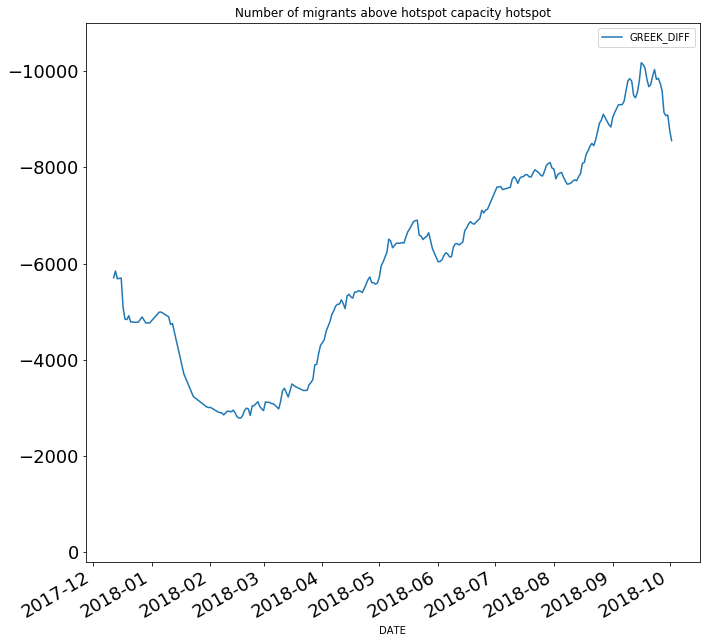

In [4]:

# subset to keep the total numbers from all islands to get the broader picture
df_complete_sliced = df_complete[['DATE','TYPE','TOTAL']]
df_complete_sliced
# pivot to make data workable
df_complete_sliced = df_complete_sliced.pivot_table(index=('DATE'),columns='TYPE', values='TOTAL').reset_index()
# sort by date
df_complete_sliced = df_complete_sliced.sort_values(by='DATE')

df_complete_sliced.plot(x="DATE", y="GREEK_DIFF", figsize=(11,11), title='Number of migrants above hotspot capacity hotspot', fontsize=18, ylim=(200,-11000)) 

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.fonttype'] = 42

# plt.savefig('viz_1.pdf')

# What is the situation on the open reception centers on the islands for the latest observation date?

To examine the most recent situation on the islands, we will repeat the steps of the previous part, keeping only the open receptions centers on the Greek islands, known as "R.I.Cs" and then generate a chart

In [5]:

columns = ['TYPE', 'LESVOS','CHIOS','SAMOS','LEROS','KOS','OTHERS','TOTAL','DATE']
df_open = pd.DataFrame(columns = columns)

for file in tqdm_notebook(files):
    print(file)
    
    df_testing = pd.read_csv(file)
    
    df_testing= df_testing.drop(df_testing.index[15:24])

    df_testing.iloc[4,0] = df_testing.iloc[4,1]

    df_testing = df_testing.drop(df_testing.index[0])

    df_testing = df_testing.drop('Unnamed: 1', axis=1)
    # rename row 0
    df_testing = df_testing.rename(index=str, columns={"Unnamed: 15": "TOTAL-CAP","TOTAL": "TOTAL-OCC","Unnamed: 13": "OTHERS-CAP","OTHER ISLANDS": "OTHERS-OCC","Unnamed: 11": "KOS-CAP","KOS": "KOS-OCC","Unnamed: 9": "LEROS-CAP", "LEROS": "LEROS-OCC", "Unnamed: 7": "SAMOS-CAP", "SAMOS": "SAMOS-OCC", "Unnamed: 5": "CHIOS-CAP", "CHIOS": "CHIOS-OCC", "Unnamed: 3": "LESVOS-CAP", "LESVOS": "LESVOS-OCC", "PLACE/LOCATION": "PLACE"})

    df_testing = df_testing.replace('NaN', np.nan)
    df_testing = df_testing.replace(np.nan,0)

    df_testing=df_testing.drop(df_testing.index[9:24])
    # drop MAKESHIFT CAMPS because they are empty 
    df_testing = df_testing.drop(df_testing.index[7])
    # drop other NGOs
    df_testing = df_testing.drop(df_testing.index[6:9])

    df_testing = df_testing[df_testing.PLACE=='R.I.C.']


    columns = ['TYPE', 'LESVOS','CHIOS','SAMOS','LEROS','KOS','OTHERS','TOTAL']
    # new df
    df_open_cleaned = pd.DataFrame(columns=columns)
    df_open_cleaned = df_open_cleaned.fillna(0) # with 0s rather than NaNs
    # Types of values
    types = ['GREEK_OCC','GREEK_CAP','GREEK_DIFF']
    df_open_cleaned['TYPE'] = types
    df_open_cleaned.set_index('TYPE', inplace=True)


    values = df_testing.iloc[-1,1::2].tolist()

    df_open_cleaned.loc['GREEK_OCC'] = values
    #GREEK_CAP

    values = df_testing.iloc[-1,2::2].tolist()
    df_open_cleaned.loc['GREEK_CAP'] = values

    df_open_cleaned['DATE'] = file

    df_open_cleaned.DATE = df_open_cleaned.DATE.str.replace('.csv', '')
    df_open_cleaned.reset_index(inplace=True)
    # concating them one by one
    df_open = pd.concat([df_open,df_open_cleaned])
    df_open.reset_index(drop=True)


df_open.DATE = df_open.DATE.str.replace('csv_data/', '')

df_open['DATE'] = pd.to_datetime(df_open['DATE'], format="%d.%m.%y")




csv_data.csv/01.02.18.csv
csv_data.csv/01.03.18.csv
csv_data.csv/01.04.18.csv
csv_data.csv/01.05.18.csv
csv_data.csv/01.06.18.csv
csv_data.csv/01.08.18.csv
csv_data.csv/01.09.18.csv
csv_data.csv/01.10.18.csv
csv_data.csv/02.03.18.csv
csv_data.csv/02.04.18.csv
csv_data.csv/02.05.18.csv
csv_data.csv/02.06.18.csv
csv_data.csv/02.07.18.csv
csv_data.csv/02.08.18.csv
csv_data.csv/02.09.18.csv
csv_data.csv/02.10.18.csv
csv_data.csv/03.03.18.csv
csv_data.csv/03.04.18.csv
csv_data.csv/03.05.18.csv
csv_data.csv/03.06.18.csv
csv_data.csv/03.08.18.csv
csv_data.csv/03.09.18.csv
csv_data.csv/04.03.18.csv
csv_data.csv/04.05.18.csv
csv_data.csv/04.06.18.csv
csv_data.csv/04.07.18.csv
csv_data.csv/04.08.18.csv
csv_data.csv/04.09.18.csv
csv_data.csv/05.01.18.csv
csv_data.csv/05.02.18.csv
csv_data.csv/05.03.18.csv
csv_data.csv/05.04.18.csv
csv_data.csv/05.05.18.csv
csv_data.csv/05.06.18.csv
csv_data.csv/05.07.18.csv
csv_data.csv/05.08.18.csv
csv_data.csv/06.01.18.csv
csv_data.csv/06.02.18.csv
csv_data.csv

Generating our second chart

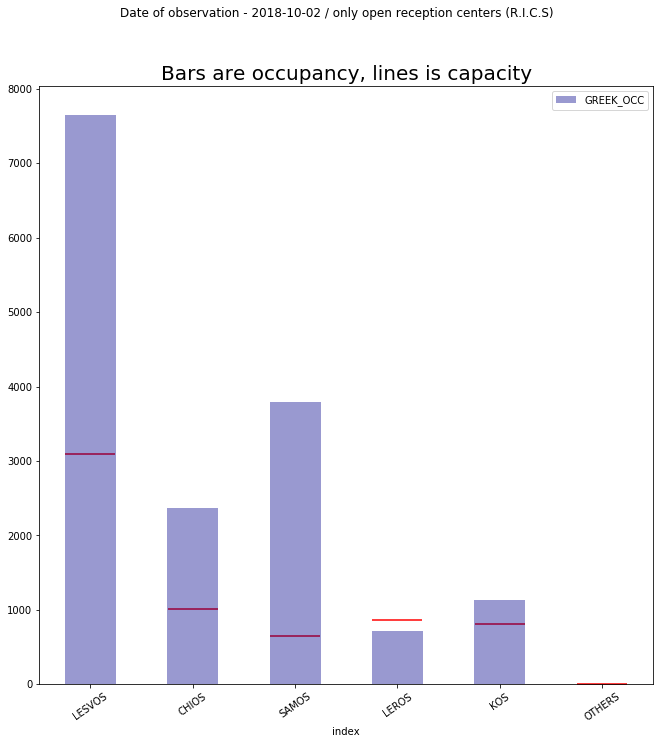

In [6]:
# preparing our data, we will need to slice the df and keep observations from the most recent date, 2nd of October 2018
df_difference = df_open[df_open.DATE == df_open.DATE.max()].transpose()
# dropping some uncessary rows
df_difference.columns = df_difference.iloc[0]

df_difference = df_difference.iloc[1:]

df_difference = df_difference.iloc[:-2]

# changing the type of column 
df_difference.GREEK_OCC = df_difference.GREEK_OCC.astype(int)
df_difference.GREEK_CAP = df_difference.GREEK_CAP.astype(int)

df_difference.drop(df_difference.columns[2:], axis=1, inplace=True)
# assigning index position for scatterplot
df_difference['position'] = [0,1,2,3,4,5]

# changing global parameters for markersize
import matplotlib as mpl

mpl.rcParams['lines.markersize'] = 50

# firing up the chart

df_difference.reset_index().plot(kind='bar',y='GREEK_OCC',x='index',figsize=(11,11), color='darkblue',alpha=0.4, rot=35)

x = df_difference.reset_index().index
y = df_difference.reset_index().GREEK_CAP

plt.scatter(x,y,marker='_', color='red')

plt.title('Bars are occupancy, lines is capacity', fontsize=20)
plt.suptitle('Date of observation - 2018-10-02 / only open reception centers (R.I.C.S)')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.fonttype'] = 42

# plt.savefig('viz_5.pdf')


# Emergency EU funding to Greece and migration flows to Greece

We have already scrapped that part, if you wish to simply continue reproducing the results, simply continue

Data on the total allocations was found in the latest EU factsheet and was converted to csv similarly as the overcapacity data
https://ec.europa.eu/home-affairs/sites/homeaffairs/files/what-we-do/policies/european-agenda-migration/20180928_managing-migration-eu-financial-support-to-greece_en.pdf

In [ ]:
# We make the directory to save our scraped data
os.mkdir('data/financing_data')

In [16]:
# scrapping the factsheet
options = webdriver.ChromeOptions()
download_folder = 'data/financing_data/'
profile = {"plugins.plugins_list": [{"enabled": False,
                                     "name": "Chrome PDF Viewer"}],
           "download.default_directory": download_folder,
           "download.extensions_to_open": ""}
options.add_experimental_option("prefs", profile)

link = 'https://ec.europa.eu/home-affairs/sites/homeaffairs/files/what-we-do/policies/european-agenda-migration/20180928_managing-migration-eu-financial-support-to-greece_en.pdf'
driver = webdriver.Chrome(chrome_options = options)
driver.get(link)

Screenshot of analysis and exporting it as csv

<img src="screenshots/screenshot_4.png">

Resuming the analysis

In [9]:
# we then read it and clean it up
df_financing = pd.read_csv('financing_data/finance_eu_mig.csv')
df_financing.columns =df_financing.columns.str.replace('\n',' ')
df_financing.columns =df_financing.columns.str.replace(' ','_')
df_financing['EU_contribution'] = df_financing['EU_contribution'].str.replace('€','')
df_financing['EU_contribution'] = df_financing['EU_contribution'].str.replace('\.m','')
df_financing['EU_contribution'] = df_financing['EU_contribution'].str.replace('m','')
df_financing['EU_contribution'] = df_financing['EU_contribution'].astype(float)

In [10]:
print('Total allocated funds from the emergency funding channels, in millions')
df_financing.EU_contribution.sum()

Total allocated funds from the emergency funding channels, in millions


1062.21

In [11]:
# rounding up and converting to euros and not millions of euros
df_financing.EU_contribution = df_financing.EU_contribution.round().astype(int)
df_financing.EU_contribution = df_financing.EU_contribution * 1000000

In [12]:
# datetime
df_financing['Date'] = pd.to_datetime(df_financing['Award_Decision_taken'])

# resampling on a 6 month basis and calculating the summed allocation
df_total_finance_6m = df_financing.resample('6M', on='Date').sum()

df_total_finance_6m

,EU_contribution
Date,
2015-01-31,11000000
2015-07-31,7000000
2016-01-31,313000000
2016-07-31,246000000
2017-01-31,205000000
2017-07-31,15000000
2018-01-31,194000000
2018-07-31,71000000


We found monthly data on migrant arrivals on the UNHCR website https://data2.unhcr.org/en/situations/mediterranean/location/5179

In [13]:
json_arrivals = pd.read_json('data/arrivals.json')

In [14]:
# Turning json list of dictionaries to df
df_arrivals = pd.DataFrame(json_arrivals['data'][1])

# dealing with unix_timestamp
df_arrivals.unix_timestamp = pd.to_numeric(df_arrivals.unix_timestamp, errors='coerce').fillna(0)
df_arrivals.unix_timestamp = df_arrivals.unix_timestamp.apply(lambda t:time.strftime('%d/%m/%Y', time.localtime(t)))
df_arrivals['Date'] = pd.to_datetime(df_arrivals.unix_timestamp)

# resampling on a 6m basis
df_arrivals_resampled_6m = df_arrivals.resample('6M', on='Date').sum()

df_arrivals_resampled_6m

,individuals,month,year
Date,,,
2014-01-31,955,1,2014
2014-07-31,12587,27,12084
2015-01-31,29190,51,12085
2015-07-31,128409,27,12090
2016-01-31,794035,51,12091
2016-07-31,92882,27,12096
2017-01-31,14546,51,12097
2017-07-31,10142,27,12102
2018-01-31,19816,51,12103


In [15]:
# drop some observations to prevent time inconsistencies between the two datasets
df_arrivals_resampled_6m = df_arrivals_resampled_6m.drop(df_arrivals_resampled_6m.index[[0,1,10]])



In [16]:
# merge the two 
allocation_merged_df = pd.concat([df_total_finance_6m, df_arrivals_resampled_6m], axis=1, join_axes=[df_total_finance_6m.index])


In [17]:
allocation_merged_df

,EU_contribution,individuals,month,year
Date,,,,
2015-01-31,11000000,29190,51,12085
2015-07-31,7000000,128409,27,12090
2016-01-31,313000000,794035,51,12091
2016-07-31,246000000,92882,27,12096
2017-01-31,205000000,14546,51,12097
2017-07-31,15000000,10142,27,12102
2018-01-31,194000000,19816,51,12103
2018-07-31,71000000,14629,27,12108


In [ ]:
# Exporting to fix chart in D3.js 
allocation_merged_df.to_csv('allocation_merged_df.csv')

# Greek Asylum + EASO by the number of asylum seekers

Data on Greek found in http://asylo.gov.gr/en/wp-content/uploads/2018/10/Dashboard-September_20181.pdf



In [18]:
# creating the dataset based on values from factshet
df_asylum = pd.DataFrame({'year': [ '2013','2014','2015','2016','2017'],'officers': [184,218,331,600,670],'asylum_seekers': [4814,9431,13187,51053,58642]})

# calculating asylum apps per officer
df_asylum['asylum_apps_per_officer'] = df_asylum.asylum_seekers / df_asylum.officers

# formating the data
df_asylum['year'] = pd.to_datetime(pd.to_datetime(df_asylum['year'], format="%Y"))
df_asylum.asylum_apps_per_officer = df_asylum.asylum_apps_per_officer.round()
df_asylum['dummy_values'] = (100 - df_asylum.asylum_apps_per_officer)
df_asylum.year = df_asylum.year.astype(str)
df_asylum


,year,officers,asylum_seekers,asylum_apps_per_officer,dummy_values
0,2013-01-01,184,4814,26.0,74.0
1,2014-01-01,218,9431,43.0,57.0
2,2015-01-01,331,13187,40.0,60.0
3,2016-01-01,600,51053,85.0,15.0
4,2017-01-01,670,58642,88.0,12.0


In [20]:

# os.mkdir('visualizations/viz_2')

/Users/ioannisantypas/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


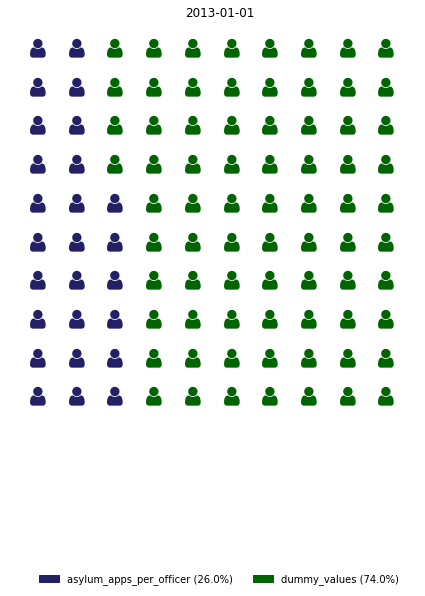

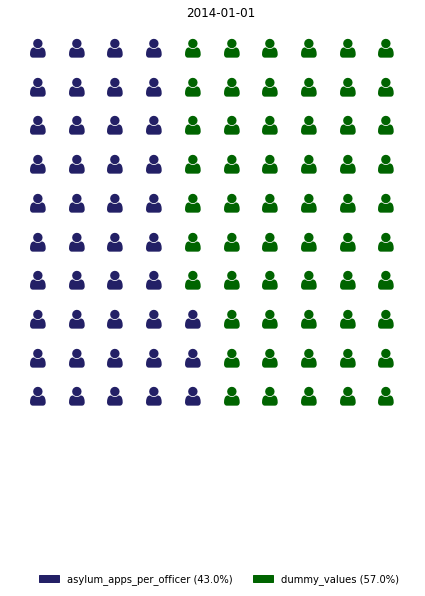

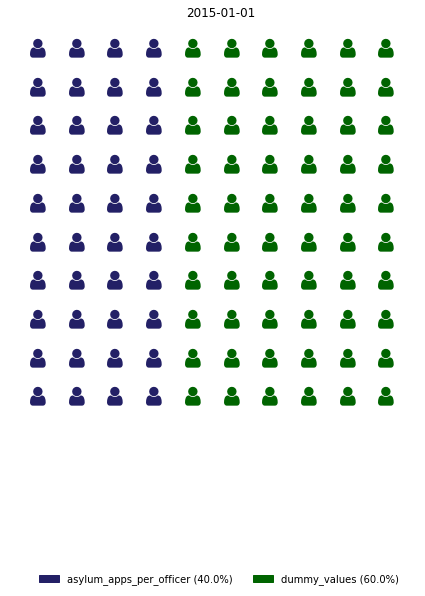

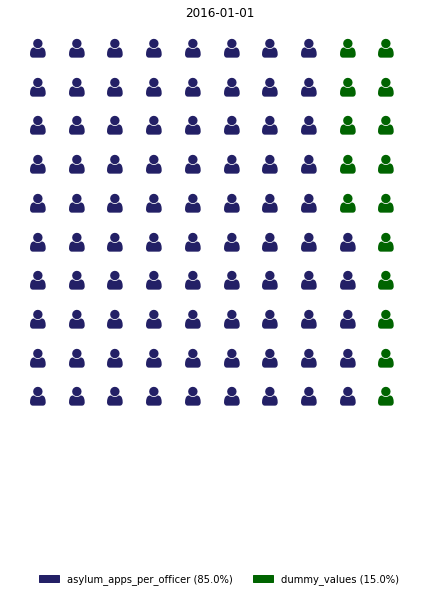

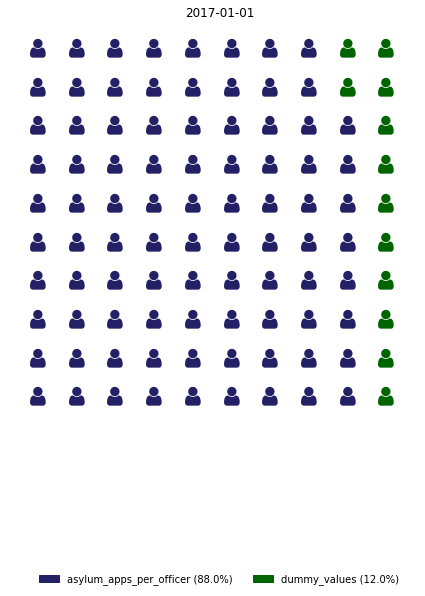

In [17]:
# Generating waffle charts with little human icons and naming them after the year

df_asylum.year = df_asylum.year.astype(str)
counter = 0
for year in  tqdm_notebook(df_asylum.year):
    data = df_asylum.loc[counter][['asylum_apps_per_officer','dummy_values']]
    fig = plt.figure(figsize=(8,8),
        FigureClass=Waffle, 
        rows=10, 
        values=data, 
        colors=("#232066",'#006400'),
        title={'label': df_asylum.year[counter], 'loc': 'center'},
        labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
        legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.5), 'ncol': len(data), 'framealpha': 0},
        icon_size=22,
        icons='user'
    )

    fig.gca().set_facecolor('#EEEEEE')
    fig.set_facecolor('white')

    plt.savefig('visualizations/viz_2/'+year +".asylum.svg", bbox_inches='tight')

    counter +=1





# Disbursed funds

Data on actually disbursed funds so far have been sent by the EU Commission to the DW
They are included below.

Those two datasets are all emergency funding given to Greece as shown in this factsheet:

https://ec.europa.eu/home-affairs/sites/homeaffairs/files/what-we-do/policies/european-agenda-migration/20180404-managing-migration-eu-financial-support-to-greece_en.pdf

* The first (df_ESI) is the table on the emergency assistance instrument which, as all EU humanitarian funding is provided directly and exclusively to humanitarian organisations such as NGOs, UN agencies and international organisations

* The second table (df_tools) is the breakdown of disbursements for the emergency assistance under AMIF and ISF.

* Because df_tools contains no description of the project, only financial data, we will use df_financing (which contains all projects, but only the amount allocated) from before to merge and match it with df_tools and associate project description to disbursed amounts 

In [21]:

df_ESI = pd.read_csv('data/funding_ESI.csv')
df_tools = pd.read_csv('data/funding_tools.csv')
df_total_financing = pd.read_csv('financing_data/finance_eu_mig.csv')

In [22]:
# formating numbers
df_ESI.Funding = df_ESI.Funding.str.replace(' ','').astype(float)
df_ESI['Percentage disburse to date'] = df_ESI['Percentage disburse to date'].str.replace('%',' ').astype(int)

# calculating the disbursed amount based on % of disbursement
df_ESI['Amount Paid'] = (df_ESI.Funding * df_ESI['Percentage disburse to date']) / 100

In [23]:
# formating numbers

df_tools['Amount allocated'] = df_tools['Amount allocated'].str.replace(',','').astype(float)
df_tools['Amount Paid'] = df_tools['Amount Paid'].str.replace(',','').astype(float)

In [24]:
# renaming some columns to prepare for merging them 
df_tools = df_tools.rename(columns={'Project Title': 'Activity'})



In [25]:
# preparing to merge
df_total_financing = df_total_financing.rename(columns={'Title of the action': 'Activity','EU contribution':'Amount Paid','Award Decision taken':'Beginning of action','Responsible Entity':'Coordinator'})
df_total_financing.columns = df_total_financing.columns.str.replace('\n',' ')


In [61]:
# There are many inconsistencies in the Activity section between the version sent by DG HOME 
# and the one scrapped from the factsheet 
# https://ec.europa.eu/home-affairs/sites/homeaffairs/files/what-we-do/policies/european-agenda-migration/20181010_managing-migration-eu-financial-support-to-greece_en.pdf
# exporting df_tools and df_total_financing to fix minor typos in Activity to match them 
# all changes are recorded in the end of the notebook

df_total_financing.to_csv('financing_data/Total_financing.csv')
df_tools.to_csv('financing_data/Tools.csv')

,Coordinator,Beginning of action,End of action,Funding,Percentage disburse to date,Activity,Type,Fund,Amount Paid
0,Danish Refugee Council,01/04/2016,31/03/2017,14700000.0,100,"Food distributions, site management support, s...",Living Assistance,HOME,14700000.0
1,International Federation of Red Cross and Red ...,16/03/2016,30/04/2017,17000000.0,100,"Basic health care, food parcels, water, sanita...",Living Assistance,HOME,17000000.0
2,Missing Children Europe,01/09/2016,30/04/2017,6567782.0,100,Multi-purpose cash assistance,Cash Transfers,HOME,6567782.0
3,UNHCR,01/04/2016,31/03/2017,62000000.0,100,Upgrading of existing shelter solutions and si...,Infrastructure support,HOME,62000000.0
4,UNHCR,01/08/2016,31/07/2017,3000000.0,100,Rehabilitation and upgrades of sites in the is...,Infrastructure support,HOME,3000000.0


In [26]:
# opening the cleaned dfs

cleaned_df_total_financing = pd.read_csv('financing_data/CLEANED_TOTAL_FINANCING.csv')
cleaned_df_tools = pd.read_csv('financing_data/CLEANED_TOOLS.csv')


In [27]:
# Perform the first merge between 
cleaned_df_total_financing = cleaned_df_total_financing[['Activity','Award Decision taken']]
df_first_merge = pd.merge(cleaned_df_tools,cleaned_df_total_financing, on='Activity',how='left')

In [28]:
# preparing for the final merge
# Some velues was not merged properly manually replacing Amount paid and date based on DG HOME data

df_first_merge = df_first_merge[['Fund','Coordinator','Activity','Amount Paid','Award Decision taken','Type']]
df_first_merge.at[10, 'Amount Paid'] = 22785980.65
df_first_merge.at[10, 'Award Decision taken'] = '04/10/2018'
df_first_merge.at[9, 'Amount Paid'] = 6434124
df_first_merge.at[13, 'Amount Paid'] =25688566
df_first_merge.at[34, 'Amount Paid']=2254000
df_first_merge.at[46, 'Amount Paid'] = 3171615.96

In [26]:
# preparing for the final merge
df_ESI = df_ESI[['Coordinator','Beginning of action','Amount Paid','Activity','Type','Fund']]
df_ESI = df_ESI.rename(columns={'Beginning of action': 'Award Decision taken'})
df_ESI['Amount Paid'] = df_ESI['Amount Paid'].round().astype(int)
df_first_merge['Amount Paid'] = df_first_merge['Amount Paid'].round().astype(int)

In [27]:
# merging 
df_finace_complete = pd.concat([df_ESI,df_first_merge], ignore_index=True)

/Users/ioannisantypas/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [28]:
# fixing some bad entries after cross checking the factsheet
df_finace_complete.at[51, 'Award Decision taken'] = '31/07/2017'
df_finace_complete.at[26,'Type'] = 'Living Assistance'
df_finace_complete['Date'] = pd.to_datetime(df_finace_complete['Award Decision taken'])

In [29]:
# shortening names to visualize them

df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Defence - General Directorate of Financial Planning and Support (GDFPS)','MoD')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('First Reception Service - Ministry of Interior and Administrative Reconstruction','Interior Ministry')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Interior and Administrative Reconstruction - Hellenic Police Headquarters','Interior Ministry')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Interior and Administrative Reconstruction - Reception and identification Service','Interior Ministry')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Interior and Administrative Reconstruction - European Development Programs Division','Interior Ministry')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Hellenic Coast Guard - Ministry of Economy, Infrastructure, Maritime Affairs & Tourism','GR Coast Guard')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('International Federation of Red Cross and Red Crescent Societies','Red Cross')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry for Infrastructure, Transport and Networks - General Secretariat for Infrastructure','Ministry of Infrastructure')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Hellenic Centre for Disease Control and Prevention HCDCP - Ministry of Public Health','Ministry of Public Health')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Asylum Service - Ministry of Interior and Administrative Reform','Ministry of Interior')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Hellenic Police - Ministry of Interior and Administrative Reconstruction- European Development Programs Division','Ministry of Interior')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('General Secretary for Co-ordination - Hellenic Republic','General Secretary')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Interior and Administrative Reform - Asylum Service','Ministry of Interior')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Health - (and HCDCP)','Ministry of Health')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('International Federation of Red Cross and Red Crescent Societies\n\n','Red Cross')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Asylum Service - Ministry of Migration Policy','Asylum Service')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Defence - General Directorate of Financial Planning and Support (GDFPS)','Ministry of Defence')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Hellenic Coast Guard - Ministry of Maritime Affairs & Insular Policy','GR Coast Guard')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Health - (and HCDCP)','Ministry of Health')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Red Cross\n\n','Red Cross')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Migration - RIS','Ministry of Migration')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Public Health','Ministry of Health')
df_finace_complete.Coordinator=df_finace_complete.Coordinator.str.replace('Ministry of Interior and Administrative Reconstruction - First Reception Service','Ministry of Interior')
df_finace_complete.Coordinator = df_finace_complete.Coordinator.str.replace('Ministry of Defence - General Directorate of Financial Planning and Support (GDFPS)','Ministry of Defence', regex=False) 


df_finace_complete.Coordinator = df_finace_complete.Coordinator.str.replace('Ministry of Defence','MoD', regex=False) 
df_finace_complete.Coordinator = df_finace_complete.Coordinator.str.replace('Ministry of Health','MoH', regex=False) 
df_finace_complete.Coordinator = df_finace_complete.Coordinator.str.replace('Interior Ministry','MoI', regex=False) 


In [30]:
#renaming a column to help us fix chart in D3
df_finace_complete.rename(columns={'Amount Paid': 'Amount_Paid'}, inplace=True)

In [31]:
# calculating disbursed funds to NGOs and Greek authorities
conditions = [
    (df_finace_complete['Coordinator'] == 'MoI'), (df_finace_complete['Coordinator'] == 'Ministry of Interior'),
    (df_finace_complete['Coordinator'] == 'MoD'), (df_finace_complete['Coordinator'] == 'GR Coast Guard'),
    (df_finace_complete['Coordinator'] == 'Ministry of Infrastructure'), (df_finace_complete['Coordinator'] == 'Asylum Service'),
    (df_finace_complete['Coordinator'] == 'MoH - (and HCDCP)'), df_finace_complete['Coordinator'] == 'MoH']
choices = ['Greek','Greek','Greek','Greek','Greek','Greek','Greek','Greek']
df_finace_complete['Authority'] = np.select(conditions, choices, default='NGO')



In [32]:
df_finace_complete.groupby('Authority')['Amount_Paid'].sum()

Authority
Greek    207572725
NGO      740927425
Name: Amount_Paid, dtype: int64

In [41]:
# exporting to work chart with D3.js
os.mkdir('D3_financing_migration')
df_finace_complete.to_csv('D3_financing_migration/finance.csv')

Values from `df_tools.Activity` will replace `df_total_financing.Activity` to match them when merging

Below are the index numbers from df_tools.Activity and corrections made from them

- index pos 32
Support the operation of the Greek Asylum Service, especially the provision of mobile asylum units on 4 border islands

- index pos 0
Ensuring and enhancing access to a fair and efficient Asylum Process in Greece

- index pos 37
Strengthening the Common European Asylum System: creating safe pathways to the European Union for persons in need of international protection

- index pos 21
Transportation, Accommodation, Alimentation of TCNs in need of international protection and/or potential asylum seekers to mainland

- index pos 42
Relocation programme from Greece to other EU Member States for beneficiaries in clear need of international protection

- index pos 40
Assisted voluntary return of third country nationals to their country of origin

- index pos 38
Emergency support to assist most vulnerable migrants stranded in Greece

- index pos 33
Open Centre for Migrants Registered for Assisted Voluntary Return (OCAVRR II)

- index pos 34
Emergency response in accommodating unaccompanied migrant children - ERACUMIC

- index pos 31
Emergency measures to enhance accommodation capacity and Site Management Support in the sites of Greece

- index pos 75
PEDIA – Providing Education and Immediate Accommodation to Migrant Children in Greece
[note that entry was not scrapped with ABBYY. It was added manually from df_tools after cross checking it with the factsheet https://ec.europa.eu/home-affairs/sites/homeaffairs/files/what-we-do/policies/european-agenda-migration/20181010_managing-migration-eu-financial-support-to-greece_en.pdf

- index pos 75
Provision of 1150 prefabricated shelter houses for the hosting of TCNs
[similar to above entry was missing and was taken from same source]

- index pos 4
I.R.R.M.Cr--Immediate Response to the Refugee-Migrant Crisis by providing them sheltering and accommodation, catering, health care and transportation

- index pos 0
IRRMCr - Immediate Response to the Refugee - Migrant Crisis by providing them sheltering and accommodation, catering, health care and transportation on the mainland

- index pos 15
Immediate enhancement of the response to the refugee - migrant crisis by providing them sheltering and accommodation, catering, health care, transportation at open accommodation, ensuring by this way health and safe living conditions for the target group

- index pos 9
Immediate enhancement of the response to the refugee - migrant crisis by providing them sheltering and accommodation, catering, health care, transportation at open accommodation centres, ensuring by this way health and safe living conditions for the target group

- index pos 10
Comprehensive Emergency Health Response to Refugee Crisis

- index pos 20
Return of third countries nationals to their country of origin (5 Sub-Actions)

- index pos 11
Ensuring a fair and efficient Asylum Process, including in the context of the implementation of the EU-Turkey agreement

- index pos 39
Supporting UNHCR Greece Emergency Response Plan and strengthening the capacity of the asylum service

- index pos 45
Support to Greece for the development of the hotspot/relocation scheme as well as for developing asylum reception capacity

- index pos 36
Support to management of Kara Tepe (Lesvos) and Souda (Chios) sites

- index pos 35
Continuation of targeted support to guarantee a smooth transition from emergency mode to stable management of the refugee and migrant situation and provision of services let by the Greek Government

- index pos 32
Continuation of support to site management of Kara Tepe (Lesvos) and targeted support to protection activities in support to the Greek Government

- index pos 41
EASO emergency support for the Greek Hotspots to strengthen their fingerprinting capacity

- index pos 24
Emergency support enhancing the operational capacity of the Greek authorities and CSOs to manage the extreme rise in refugee and illegal migrants' flows into Greek national and European territory

- index pos 22
Administrative reinforcement of First Reception Service

- index pos 16
Enhancement of human resources in First Reception Centres

- index pos 18
Immediate enhancement of the response to the public health challenge presented by the refugee/migrant emergency on the front line of first reception in the Eastern Aegean Sea

- index pos 29
Emergency assistance covering staff related costs in order to ensure a high level domain awareness of the severely affected Eastern Aegean EU external borders and to minimize the losses of human lives at sea

- index pos 28
Emergency assistance for the procurement of Search & Rescue Equipment to avert losses of migrants’ life at sea

- index pos 26
Emergency assistance covering unexpected maintenance and repair costs related to the intense use of HCG maritime assets as well as Search & Rescue and medical Equipment in view of ensuring a high level domain awareness of the severely affected Eastern Aegean EU external borders and to minimize the losses of human lives at sea

- index pos 23
Emergency assistance covering the deployment of additional staff members and Special Forces to the severely affected Eastern Aegean HCG Authorities in order to improve the management of the intense migratory flows.

- index pos 25
Reinforcement of the Eastern Aegean Police Agencies

- index pos 2
IRRMCr - Fylakio - Immediate Response to the Refugee - Migrant Crisis by providing them sheltering and accommodation, catering, health care and transportation on the mainland

- index pos 14
Immediate enhancement of the response to the refugee - migrant crisis by providing them sheltering and accommodation, catering, health care, transportation at hot spots, ensuring by this way health and safe living conditions for the target group

- index pos 8
Immediate enhancement of the response to the refugee - migrant crisis by providing them sheltering and accommodation, catering, health care, transportation at hot spots, ensuring by this way health and safe living conditions for the target group

- index pos 3
Provision of security services for RICs in the Eastern Aegean islands

- index pos 12
Upgrading the existing IT-system of the Hellenic Police for the registration process of TCNs

- index pos 13
Provisional services to TCNs and operational support to the Hellenic Police services at the external borders

- index pos 27
Emergency assistance in support of the organisation, provision of legal information and interpretation for the effective management of immigration flows in the Eastern External Borders

- index pos 7
Emergency assistance for the effective management of immigration flows in the Greek territory

- index pos 6
Construction works of the sewer system and water supply network in Samos

- index pos 19
Reinforcement of the Orestiada Police Directorate with police personnel

- index pos 1
Provisional services to the TCNs and operational support to the Reception and Identification Centre (RIC) in the Evros region at the external borders

- index pos 44
Strengthening of the first reception response to new arrivals on the Aegean Islands and in the region of Evros in Greece. New Arrivals Intervention – phase II

- index pos 43
Strengthening of the first reception response to new arrivals in mixed migratory movements on the Aegean islands

- index pos 45
Support to Greece for the development of the hotspot/relocation scheme as well as for developing asylum reception capacity
[note in the note sent by DG HOME the amount in index pos 47 of df_tools is listed as 5000000. In the factsheet the amount is 80 broken in two sub tranches, one of 75 for AMIF another 5 for ISF. In df_tools the ISF is shown and in order to merge the amounts correctly we will change the value in Total_financing to 5m as the rest 75 is listed in df_ESI

They are downloaded and renamed as `CLEANED_TOOLS.csv` and `CLEANED_TOTAL_FINANCING.csv`